# pnp, c2d, stericify

*Johannes Hörmann, 2020*

from continuous electrochemical double layer theory to discrete coordinate sets

In [1]:
# for dynamic module reload during testing, code modifications take immediate effect
%load_ext autoreload
%autoreload 2

In [2]:
# stretching notebook width across whole window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# basics
import logging
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

In [4]:
# sampling
from scipy import interpolate
from matscipy.electrochemistry import continuous2discrete
from matscipy.electrochemistry import get_histogram
from matscipy.electrochemistry.utility import plot_dist

In [5]:
# electrochemistry basics
from matscipy.electrochemistry import debye, ionic_strength

In [6]:
# Poisson-Bolzmann distribution
from matscipy.electrochemistry.poisson_boltzmann_distribution import gamma, potential, concentration, charge_density

In [7]:
# Poisson-Nernst-Planck solver
from matscipy.electrochemistry import PoissonNernstPlanckSystem

In [8]:
# 3rd party file output
import ase
import ase.io

In [9]:
# PoissonNernstPlanckSystem makes extensive use of Python's logging module

# configure logging: verbosity level and format as desired
standard_loglevel   = logging.INFO
# standard_logformat  = ''.join(("%(asctime)s",
#  "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"))
standard_logformat  = "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"

# reset logger if previously loaded
logging.shutdown()
logging.basicConfig(level=standard_loglevel,
                    format=standard_logformat,
                    datefmt='%m-%d %H:%M')

# in Jupyter notebooks, explicitly modifying the root logger necessary
logger = logging.getLogger()
logger.setLevel(standard_loglevel)

# remove all handlers
for h in logger.handlers: logger.removeHandler(h)

# create and append custom handles
ch = logging.StreamHandler()
formatter = logging.Formatter(standard_logformat)
ch.setFormatter(formatter)
ch.setLevel(standard_loglevel)
logger.addHandler(ch)

In [10]:
# Test 1
logging.info("Root logger")

[ <ipython-input-10-adec08aea02d>:2 - <module>() ]: Root logger


In [11]:
# Test 2
logger.info("Root Logger")

[ <ipython-input-11-4335e316391c>:2 - <module>() ]: Root Logger


In [12]:
# Debug Test
logging.debug("Root logger")

## Test case 1: PNP interface system, 0.1 mM NaCl, positive potential u = 0.05 V

In [56]:
# Test case parameters
c=[1000.0, 1000.0]
z=[ 1, -1]
L=20e-9 # 20 nm
a=28e-9 # 28 x 28 nm area
# delta_u=0.05
delta_u=1.2 # V

In [315]:
# expected number of ions in volume:
V = L*a**2
Nref = c[0]*V*sc.Avogadro

In [58]:
# define desired system
pnp = PoissonNernstPlanckSystem(c, z, L, delta_u=delta_u,e=1e-15)
# constructor takes keyword arguments
#   c=array([0.1, 0.1]), z=array([ 1, -1]), L=1e-07, T=298.15, delta_u=0.05, relative_permittivity=79, vacuum_permittivity=8.854187817620389e-12, R=8.3144598, F=96485.33289
# with default values set for 0.1 mM NaCl aqueous solution across 100 nm  and 0.05 V potential drop

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               2e-08
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S                0
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                  1.2
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [59]:
pnp.useStandardCellBC()

[ poisson_nernst_planck_solver.py:403 - useStandardCellBC() ]: Left hand side Dirichlet boundary condition u0 =  23.35  
[ poisson_nernst_planck_solver.py:405 - useStandardCellBC() ]: Right hand side Dirichlet boundary condition u1 = -23.35  
[ poisson_nernst_planck_solver.py:414 - useStandardCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:417 - useStandardCellBC() ]: Ion species 00 number conservation constraint N0 = 65.54   
[ poisson_nernst_planck_solver.py:414 - useStandardCellBC() ]: Ion species 01 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:417 - useStandardCellBC() ]: Ion species 01 number conservation constraint N0 = 65.54   


In [60]:
pnp.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                         0.3277
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [61]:
# pnp.output = True # let's Newton solver display convergence plots
uij, nij, lamj = pnp.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-15
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 6.71e-01, norm(dx) = 1.30e+02, norm(F) = 3.30e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 2.65e+00, norm(dx) = 2.99e+02, norm(F) = 1.61e+02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 3.59e-01, norm(dx) = 1.32e+02, norm(F) = 4.42e+01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 6.61e-02, norm(dx) = 1.76e+01, norm(F) = 5.13e+00
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 4.79e-03, norm(dx) = 1.35e+00, norm(F) = 1.95e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    5: norm(dx)/norm(x) = 1.82e-04, norm(dx) = 5.14e-02, norm(F) = 1.43e-03
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    6: norm(dx)/norm(x) = 4.05e-08, norm(dx) = 1.14e-05, 

### Validation: Analytical half-space solution & Numerical finite-size PNP system

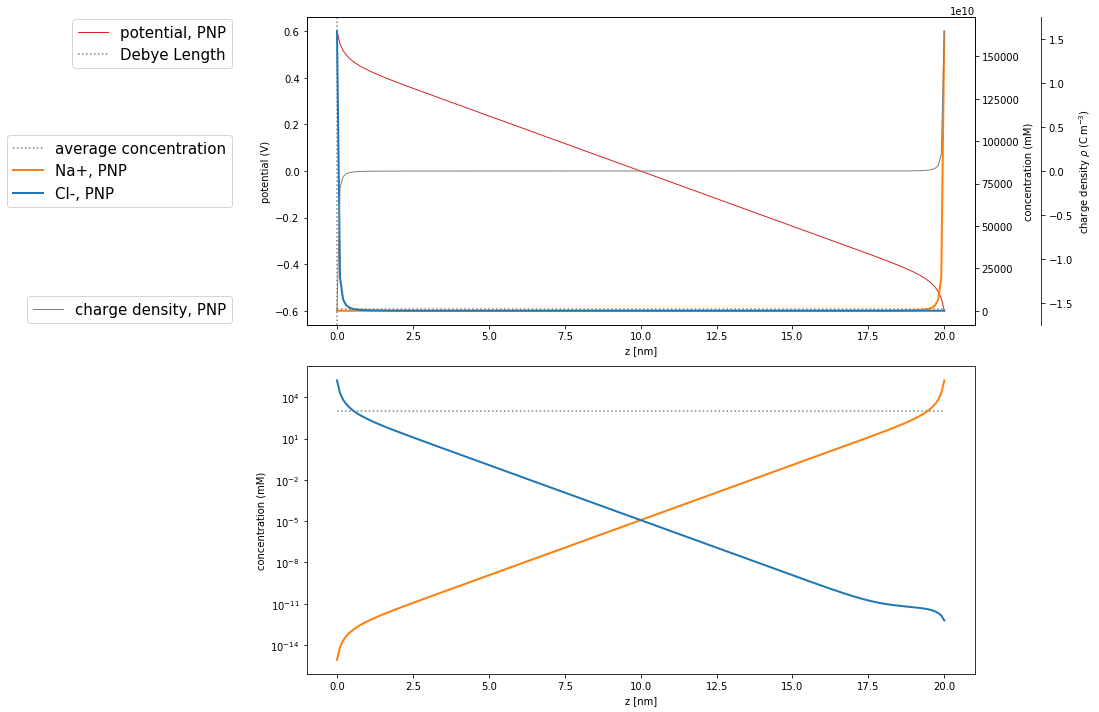

In [63]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)

deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.set_xlabel('z [nm]')
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')
ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_xlabel('z [nm]')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

#### Potential at left and right hand side of domain

In [220]:
(pnp.potential[0],pnp.potential[-1])

(0.6, -0.6)

#### Residual cation flux at interfaces

In [221]:
( pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,0), pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(7.703719777548943e-34, 2.1316282072803006e-14)

#### Residual anion flux at interfaces

In [222]:
(pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,1),  pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(-2.1316282072803006e-14, 2.1316282072803006e-14)

#### Cation concentration at interfaces

In [223]:
(pnp.concentration[0,0],pnp.concentration[0,-1])

(8.564375692814188e-16, 164778.81660499013)

#### Anion concentration at interfaces

In [224]:
(pnp.concentration[1,0],pnp.concentration[1,-1])

(164778.81660499016, 6.208507009685056e-13)

#### Equilibrium cation and anion amount

In [69]:
( pnp.numberConservationConstraint(pnp.xij1,0,0), pnp.numberConservationConstraint(pnp.xij1,1,0) )

(65.53660752997082, 65.53660752997088)

#### Initial cation and anion amount

In [70]:
( pnp.numberConservationConstraint(pnp.xi0,0,0), pnp.numberConservationConstraint(pnp.xi0,1,0) )

(65.53660752997085, 65.53660752997085)

#### Species conservation

In [71]:
(pnp.numberConservationConstraint(pnp.xij1,0,
                                 pnp.numberConservationConstraint(pnp.xi0,0,0)), 
 pnp.numberConservationConstraint(pnp.xij1,1,
                                 pnp.numberConservationConstraint(pnp.xi0,1,0)) )

(-2.842170943040401e-14, 2.842170943040401e-14)

Stern layer

In [191]:
# Test case parameters
c=[1000.0, 1000.0]
z=[ 1, -1]
L=20e-9 # 20 nm
a=28e-9 # 28 x 28 nm area
# delta_u=0.05
delta_u=0.5 # V

In [192]:
# expected number of ions in volume:
V = L*a**2
c[0]*V*sc.Avogadro

9442.716863776

In [193]:
lambda_S =  8e-10 # 0.5 nm Stern layer

In [194]:
pnp_no_compact_layer = PoissonNernstPlanckSystem(c,z,L,delta_u=delta_u, e=1e-12)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               2e-08
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S                0
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                  0.5
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [195]:
pnp_with_explicit_compact_layer = PoissonNernstPlanckSystem(c,z,L, delta_u=delta_u,lambda_S=lambda_S, e=1e-12)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               2e-08
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S            8e-10
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                  0.5
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [196]:
pnp_with_implicit_compact_layer = PoissonNernstPlanckSystem(c,z,L, delta_u=delta_u,lambda_S=lambda_S, e=1e-12)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c               1000
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               2e-08
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S            8e-10
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                  0.5
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [197]:
pnp_no_compact_layer.useStandardCellBC()

[ poisson_nernst_planck_solver.py:403 - useStandardCellBC() ]: Left hand side Dirichlet boundary condition u0 =  9.73   
[ poisson_nernst_planck_solver.py:405 - useStandardCellBC() ]: Right hand side Dirichlet boundary condition u1 = -9.73   
[ poisson_nernst_planck_solver.py:414 - useStandardCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:417 - useStandardCellBC() ]: Ion species 00 number conservation constraint N0 = 65.54   
[ poisson_nernst_planck_solver.py:414 - useStandardCellBC() ]: Ion species 01 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:417 - useStandardCellBC() ]: Ion species 01 number conservation constraint N0 = 65.54   


In [198]:
pnp_with_explicit_compact_layer.useSternLayerCellBC(implicit=False)

[ poisson_nernst_planck_solver.py:468 - useSternLayerCellBC() ]: Explicitly treating Stern layer as uniformly charged regions
[ poisson_nernst_planck_solver.py:475 - useSternLayerCellBC() ]: Left hand side Dirichlet boundary condition u0 =  9.73   
[ poisson_nernst_planck_solver.py:477 - useSternLayerCellBC() ]: Right hand side Dirichlet boundary condition u1 = -9.73   
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:490 - useSternLayerCellBC() ]: Ion species 00 number conservation constraint N0 = 65.54   
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 01 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:490 - useSternLayerCellBC() ]: Ion species 01 number conservation constraint N0 = 65.54   


In [199]:
pnp_with_implicit_compact_layer.useSternLayerCellBC(implicit=True)

[ poisson_nernst_planck_solver.py:444 - useSternLayerCellBC() ]: Implicitly treating Stern layer via Robin BC
[ poisson_nernst_planck_solver.py:455 - useSternLayerCellBC() ]: reduced cropped domain size L*              60.29
[ poisson_nernst_planck_solver.py:457 - useSternLayerCellBC() ]: shifted reduced reference position x0*      2.621
[ poisson_nernst_planck_solver.py:460 - useSternLayerCellBC() ]:  Left hand side Robin boundary condition u0 + lambda_S*dudx =  9.73   
[ poisson_nernst_planck_solver.py:462 - useSternLayerCellBC() ]: Right hand side Robin boundary condition u1 + lambda_S*dudx = -9.73   
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:490 - useSternLayerCellBC() ]: Ion species 00 number conservation constraint N0 = 60.29   
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 01 left hand side concentration Flux bo

In [200]:
pnp_no_compact_layer.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                         0.3277
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [201]:
pnp_with_explicit_compact_layer.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                         0.3277
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [202]:
pnp_with_implicit_compact_layer.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                         0.3015
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [203]:
xij_no_compact_layer = pnp_no_compact_layer.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-12
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 8.83e-01, norm(dx) = 7.29e+01, norm(F) = 1.38e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 9.40e+00, norm(dx) = 3.86e+02, norm(F) = 3.68e+01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 5.98e-01, norm(dx) = 2.43e+02, norm(F) = 6.87e+00
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 4.16e-01, norm(dx) = 7.00e+01, norm(F) = 1.92e+01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 8.37e-02, norm(dx) = 1.97e+01, norm(F) = 9.20e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    5: norm(dx)/norm(x) = 6.50e-02, norm(dx) = 1.41e+01, norm(F) = 2.71e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    6: norm(dx)/norm(x) = 6.08e-03, norm(dx) = 1.40e+00, 

In [204]:
xij_with_explicit_compact_layer = pnp_with_explicit_compact_layer.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-12
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 8.07e-01, norm(dx) = 6.66e+01, norm(F) = 1.38e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 2.86e+00, norm(dx) = 1.66e+02, norm(F) = 8.73e+00
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 5.09e-01, norm(dx) = 1.03e+02, norm(F) = 1.53e+01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 2.07e-01, norm(dx) = 2.40e+01, norm(F) = 6.25e+00
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 4.35e-02, norm(dx) = 5.77e+00, norm(F) = 3.52e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    5: norm(dx)/norm(x) = 1.23e-02, norm(dx) = 1.67e+00, norm(F) = 1.36e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    6: norm(dx)/norm(x) = 1.42e-03, norm(dx) = 1.93e-01, 

In [205]:
xij_with_implicit_compact_layer = pnp_with_implicit_compact_layer.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-12
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 9.19e-01, norm(dx) = 7.59e+01, norm(F) = 1.20e+00
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 4.24e-01, norm(dx) = 9.70e+00, norm(F) = 2.76e+00
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 1.72e-02, norm(dx) = 4.51e-01, norm(F) = 1.58e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 2.32e-02, norm(dx) = 6.12e-01, norm(F) = 3.57e-02
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 1.77e-02, norm(dx) = 4.65e-01, norm(F) = 4.26e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    5: norm(dx)/norm(x) = 2.51e-03, norm(dx) = 6.60e-02, norm(F) = 6.34e-03
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    6: norm(dx)/norm(x) = 2.85e-03, norm(dx) = 7.49e-02, 

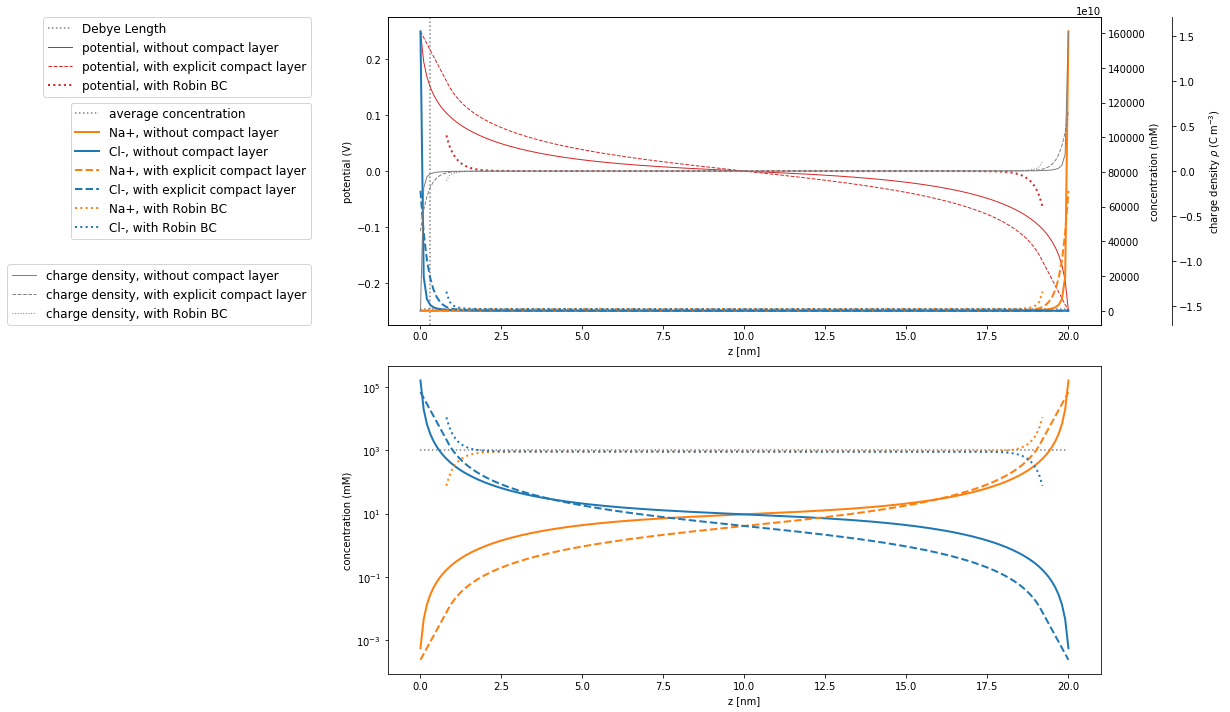

In [206]:
x = np.linspace(0,L,100)

deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[18,10])

# 1 - potentials
ax1.axvline(x=deb/sc.nano, label='Debye Length', color='grey', linestyle=':')
ax1.plot(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.potential, marker='', color='tab:red', label='potential, without compact layer', linewidth=1, linestyle='-')
ax1.plot(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.potential, marker='', color='tab:red', label='potential, with explicit compact layer', linewidth=1, linestyle='--')
ax1.plot(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.potential, marker='', color='tab:red', label='potential, with Robin BC', linewidth=2, linestyle=':')

# 2 - conencentratiosn
ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')

ax2.plot(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, without compact layer', linewidth=2, linestyle='-')
ax2.plot(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, without compact layer', linewidth=2, linestyle='-')

ax2.plot(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, with explicit compact layer', linewidth=2, linestyle='--')
ax2.plot(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, with explicit compact layer', linewidth=2, linestyle='--')

ax2.plot(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, with Robin BC', linewidth=2, linestyle=':')
ax2.plot(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, with Robin BC', linewidth=2, linestyle=':')

# 3 - charge densities
ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)
ax3.plot(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.charge_density, label='charge density, without compact layer', color='grey', linewidth=1, linestyle='-')
ax3.plot(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.charge_density, label='charge density, with explicit compact layer', color='grey', linewidth=1, linestyle='--')
ax3.plot(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.charge_density, label='charge density, with Robin BC', color='grey', linewidth=1, linestyle=':')

# 4 - concentrations, semi log
ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')

ax4.semilogy(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, without compact layer', linewidth=2, linestyle='-')
ax4.semilogy(pnp_no_compact_layer.grid/sc.nano, pnp_no_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, without compact layer', linewidth=2, linestyle='-')

ax4.semilogy(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, with explicit compact layer', linewidth=2, linestyle='--')
ax4.semilogy(pnp_with_explicit_compact_layer.grid/sc.nano, pnp_with_explicit_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, with explicit compact layer', linewidth=2, linestyle='--')

ax4.semilogy(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.concentration[0], marker='', color='tab:orange', label='Na+, with Robin BC', linewidth=2, linestyle=':')
ax4.semilogy(pnp_with_implicit_compact_layer.grid/sc.nano, pnp_with_implicit_compact_layer.concentration[1], marker='', color='tab:blue', label='Cl-, with Robin BC', linewidth=2, linestyle=':')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
#ax3.yaxis.set_major_formatter(formatter)
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-2,10), useOffset=False, useMathText=False)
ax4.set_xlabel('z [nm]')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=12)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=12)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=12)

fig.tight_layout()
plt.show()

In [207]:
from scipy import interpolate, integrate

In [231]:
D_no_compact_layer = [ interpolate.interp1d(pnp_no_compact_layer.grid,c) for c in pnp_no_compact_layer.concentration ]

In [232]:
integral_no_compact_layer = [ integrate.quad( D, pnp_no_compact_layer.grid[0] , pnp_no_compact_layer.grid[-1] )[0] for D in D_no_compact_layer]

In [233]:
cave_no_compact_layer = [ integral / L for integral in integral_no_compact_layer ]

In [234]:
cave_no_compact_layer # mM

[602.4595136934513, 602.459513693451]

In [235]:
D_with_explicit_compact_layer = [ interpolate.interp1d(pnp_with_explicit_compact_layer.grid,c) for c in pnp_with_explicit_compact_layer.concentration ]

In [236]:
integral_with_implicict_compact_layer = [ integrate.quad( D, pnp_with_explicit_compact_layer.grid[0] , pnp_with_explicit_compact_layer.grid[-1] )[0] for D in D_with_explicit_compact_layer]

In [237]:
cave_with_explicit_compact_layer = [ integral / L for integral in integral_with_implicict_compact_layer ]

In [238]:
cave_with_explicit_compact_layer # mM

[832.0469056296562, 832.04690562966]

In [239]:
D_with_implicit_compact_layer = [ interpolate.interp1d(pnp_with_implicit_compact_layer.grid,c) for c in pnp_with_implicit_compact_layer.concentration ]

In [240]:
integral_with_implicict_compact_layer = [ integrate.quad( D, pnp_with_implicit_compact_layer.grid[0] , pnp_with_implicit_compact_layer.grid[-1] )[0] for D in D_with_implicit_compact_layer]

In [241]:
cave_with_implicit_compact_layer = [ integral / (L-2*lambda_S) for integral in integral_with_implicict_compact_layer ]

In [242]:
cave_with_implicit_compact_layer # mM

[977.261479171781, 977.2431450026841]

In [230]:
#### Potential at left and right hand side of domain

logger.info("Potential at left and right hand side of domain")
logger.info("No compact layer:       {: 8.4e}, {: 8.4e}".format(pnp_no_compact_layer.potential[0],pnp_no_compact_layer.potential[-1]))
logger.info("Explicit compact layer: {: 8.4e}, {: 8.4e}".format(pnp_with_explicit_compact_layer.potential[0],pnp_with_explicit_compact_layer.potential[-1]))
logger.info("Implicit compact layer: {: 8.4e}, {: 8.4e}".format(pnp_with_implicit_compact_layer.potential[0],pnp_with_implicit_compact_layer.potential[-1]))


#### Residual cation flux at interfaces
logger.info("")
logger.info("Residual cation flux at interfaces")
logger.info("No compact layer:       {: 8.4e}, {: 8.4e}".format(pnp_no_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_no_compact_layer.xij1,0), pnp_no_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_no_compact_layer.xij1,0) ))
logger.info("Explicit compact layer: {: 8.4e}, {: 8.4e}".format(pnp_with_explicit_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_with_explicit_compact_layer.xij1,0), pnp_with_explicit_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_with_explicit_compact_layer.xij1,0) ))
logger.info("Implicit compact layer: {: 8.4e}, {: 8.4e}".format(pnp_with_implicit_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_with_implicit_compact_layer.xij1,0), pnp_with_implicit_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_with_implicit_compact_layer.xij1,0) ))

#### Residual anion flux at interfaces
logger.info("")
logger.info("Residual anion flux at interfaces")
logger.info("No compact layer:       {: 8.4e}, {: 8.4e}".format( pnp_no_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_no_compact_layer.xij1,1), pnp_no_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_no_compact_layer.xij1,1) ))
logger.info("Explicit compact layer: {: 8.4e}, {: 8.4e}".format( pnp_with_explicit_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_with_explicit_compact_layer.xij1,1), pnp_with_explicit_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_with_explicit_compact_layer.xij1,1) ))
logger.info("Implicit compact layer: {: 8.4e}, {: 8.4e}".format( pnp_with_implicit_compact_layer.leftControlledVolumeSchemeFluxBC(pnp_with_implicit_compact_layer.xij1,1), pnp_with_implicit_compact_layer.rightControlledVolumeSchemeFluxBC(pnp_with_implicit_compact_layer.xij1,1) ))


#### Cation concentration at interfaces
logger.info("")
logger.info("Cation concentration at interfaces")
logger.info("No compact layer:       {: 8.4e}, {: 8.4e}".format(pnp_no_compact_layer.concentration[0,0],pnp_no_compact_layer.concentration[0,-1]))
logger.info("Explicit compact layer: {: 8.4e}, {: 8.4e}".format(pnp_with_explicit_compact_layer.concentration[0,0],pnp_with_explicit_compact_layer.concentration[0,-1]))
logger.info("Implicit compact layer: {: 8.4e}, {: 8.4e}".format(pnp_with_implicit_compact_layer.concentration[0,0],pnp_with_implicit_compact_layer.concentration[0,-1]))

#### Anion concentration at interfaces
logger.info("")
logger.info("Anion concentration at interfaces")
logger.info("No compact layer:       {: 8.4e}, {: 8.4e}".format(pnp_no_compact_layer.concentration[1,0],pnp_no_compact_layer.concentration[1,-1]))
logger.info("Explicit compact layer: {: 8.4e}, {: 8.4e}".format(pnp_with_explicit_compact_layer.concentration[1,0],pnp_with_explicit_compact_layer.concentration[1,-1]))
logger.info("Implicit compact layer: {: 8.4e}, {: 8.4e}".format(pnp_with_implicit_compact_layer.concentration[1,0],pnp_with_implicit_compact_layer.concentration[1,-1]))

#### Equilibrium cation and anion amount
logger.info("")
logger.info("Equilibrium cation and anion amount")
logger.info("No compact layer:       {: 8.4e}, {: 8.4e}".format( pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xij1,0,0), pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xij1,1,0) ))
logger.info("Explicit compact layer: {: 8.4e}, {: 8.4e}".format( pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xij1,0,0), pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xij1,1,0) ))
logger.info("Implicit compact layer: {: 8.4e}, {: 8.4e}".format( pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xij1,0,0), pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xij1,1,0) ))

#### Initial cation and anion amount
logger.info("")
logger.info("Equilibrium cation and anion amount")
logger.info("No compact layer:       {: 8.4e}, {: 8.4e}".format( pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xi0,0,0), pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xi0,1,0) ))
logger.info("Explicit compact layer: {: 8.4e}, {: 8.4e}".format( pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xi0,0,0), pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xi0,1,0) ))
logger.info("Implicit compact layer: {: 8.4e}, {: 8.4e}".format( pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xi0,0,0), pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xi0,1,0) ))

#### Species conservation
logger.info("")
logger.info("Species conservation (cations, anions)")
logger.info("No compact layer:       {: 8.4e}, {: 8.4e}".format(
    pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xij1,0,
                                 pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xi0,0,0)), 
    pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xij1,1,
                                 pnp_no_compact_layer.numberConservationConstraint(pnp_no_compact_layer.xi0,1,0)) ) )
logger.info("Explicit compact layer: {: 8.4e}, {: 8.4e}".format( 
    pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xij1,0,
                                 pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xi0,0,0)), 
    pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xij1,1,
                                 pnp_with_explicit_compact_layer.numberConservationConstraint(pnp_with_explicit_compact_layer.xi0,1,0)) ) )
logger.info("Implicit compact layer: {: 8.4e}, {: 8.4e}".format(
    pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xij1,0,
                                 pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xi0,0,0)), 
    pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xij1,1,
                                 pnp_with_implicit_compact_layer.numberConservationConstraint(pnp_with_implicit_compact_layer.xi0,1,0)) ) )




[ <ipython-input-230-c16ae3627214>:3 - <module>() ]: Potential at left and right hand side of domain
[ <ipython-input-230-c16ae3627214>:4 - <module>() ]: No compact layer:        2.5000e-01, -2.5000e-01
[ <ipython-input-230-c16ae3627214>:5 - <module>() ]: Explicit compact layer:  2.5000e-01, -2.5000e-01
[ <ipython-input-230-c16ae3627214>:6 - <module>() ]: Implicit compact layer:  6.3835e-02, -6.3835e-02
[ <ipython-input-230-c16ae3627214>:10 - <module>() ]: 
[ <ipython-input-230-c16ae3627214>:11 - <module>() ]: Residual cation flux at interfaces
[ <ipython-input-230-c16ae3627214>:12 - <module>() ]: No compact layer:       -4.2352e-22, -2.1316e-14
[ <ipython-input-230-c16ae3627214>:13 - <module>() ]: Explicit compact layer:  1.5882e-22,  0.0000e+00
[ <ipython-input-230-c16ae3627214>:14 - <module>() ]: Implicit compact layer:  4.5175e-08, -2.0365e-06
[ <ipython-input-230-c16ae3627214>:17 - <module>() ]: 
[ <ipython-input-230-c16ae3627214>:18 - <module>() ]: Residual anion flux at interfac

In [389]:
pnp_with_explicit_compact_layer.Ni

201

In [390]:
np.sum(pnp_with_explicit_compact_layer.nij[0]*pnp_with_explicit_compact_layer.dx)

65.8642905676207

In [391]:
pnp_with_explicit_compact_layer.L_scaled

65.53660752997084

In [392]:
np.sum(pnp_with_explicit_compact_layer.nij[0]*pnp_with_explicit_compact_layer.dx)  / (pnp_with_explicit_compact_layer.L_scaled+pnp_with_explicit_compact_layer.dx)

1.0000000000000002

In [393]:
dx = np.mean((np.roll(pnp_with_explicit_compact_layer.grid,-1)-pnp_with_explicit_compact_layer.grid)[:-1])

In [394]:
np.sum(pnp_with_explicit_compact_layer.concentration[0])/pnp_with_explicit_compact_layer.Ni

1000.0

In [395]:
pnp_with_explicit_compact_layer.c_unit*V*sc.Avogadro

9442.716863776

In [396]:
Nref

9442.716863776

In [397]:
np.sum(pnp_with_explicit_compact_layer.nij[0]*pnp_with_explicit_compact_layer.dx) * pnp_with_explicit_compact_layer.N / pnp_with_explicit_compact_layer.Ni

65.53660752997085

In [398]:
D_with_explicit_compact_layer = [ interpolate.interp1d(pnp_with_explicit_compact_layer.grid,c) for c in pnp_with_explicit_compact_layer.concentration ]

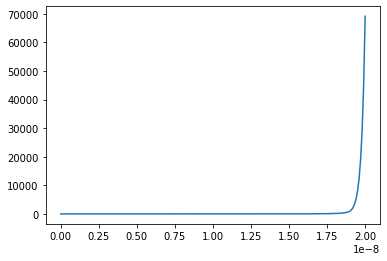

In [399]:
plt.plot( pnp_with_explicit_compact_layer.grid, D_with_explicit_compact_layer[0](pnp_with_explicit_compact_layer.grid) )

In [444]:
integral_with_explicit_compact_layer = [ 
    integrate.quad( D, pnp_with_explicit_compact_layer.grid[0] , pnp_with_explicit_compact_layer.grid[-1], limit=1000, epsrel=1e-12 )[0] for D in D_with_explicit_compact_layer]

In [447]:
integral_with_explicit_compact_layer[0]

1.6640938112593124e-05

In [446]:
cave_with_explicit_compact_layer = [ integral / L for integral in integral_with_explicit_compact_layer ]

In [430]:
cave_with_explicit_compact_layer # mM

[832.0469056296562, 832.04690562966]

In [441]:
integral_with_explicit_compact_layer[0]

1.6640938112593124e-05

In [448]:
L

2e-08

In [449]:
pnp_with_explicit_compact_layer.grid[-1]

2e-08

In [457]:
L/dx

200.0

In [470]:
np.sum(D_with_explicit_compact_layer[0](pnp_with_explicit_compact_layer.grid)*dx)

2.01e-05

## Sample application of 1D electrochemical cell model:

We want to fill a gap of 3 nm between gold electrodes with 0.2 wt % NaCl aqueous solution, apply a small potential difference and generate an initial configuration for LAMMPS within a cubic box:

In [404]:
box_Ang=np.array([50.,50.,50.]) # Angstrom

In [405]:
box_m = box_Ang*sc.angstrom

In [109]:
box_m

array([5.e-09, 5.e-09, 5.e-09])

In [110]:
vol_AngCube = box_Ang.prod() # Angstrom^3

In [111]:
vol_mCube = vol_AngCube*sc.angstrom**3

With a concentration of 0.2 wt %, we are close to NaCl's solubility limit in water.
We estimate molar concentrations and atom numbers in our box:

In [112]:
# enter number between 0 ... 0.2 
weight_concentration_NaCl = 0.2 # wt %
# calculate saline mass density g/cm³
saline_mass_density_kg_per_L  = 1 + weight_concentration_NaCl * 0.15 / 0.20 # g / cm^3, kg / L
# see https://www.engineeringtoolbox.com/density-aqueous-solution-inorganic-sodium-salt-concentration-d_1957.html

In [113]:
saline_mass_density_g_per_L = saline_mass_density_kg_per_L*sc.kilo

In [114]:
molar_mass_H2O = 18.015 # g / mol
molar_mass_NaCl  = 58.44 # g / mol

In [115]:
cNaCl_M = weight_concentration_NaCl*saline_mass_density_g_per_L/molar_mass_NaCl # mol L^-1

In [116]:
cNaCl_mM = np.round(cNaCl_M/sc.milli) # mM

In [117]:
cNaCl_mM

3936.0

In [118]:
n_NaCl = np.round(cNaCl_mM*vol_mCube*sc.value('Avogadro constant'))

In [119]:
n_NaCl

296.0

In [120]:
c = [cNaCl_mM,cNaCl_mM]
z = [1,-1]
L=box_m[2]
lamda_S = 2.0e-10
delta_u  = 0.5

In [121]:
pnp = PoissonNernstPlanckSystem(c,z,L, lambda_S=lambda_S, delta_u=delta_u, N=200, maxit=20, e=1e-6)

[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 00 concentration c               3936
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 00 number charge z                  1
[ poisson_nernst_planck_solver.py:1004 - __init__() ]: ion species 01 concentration c               3936
[ poisson_nernst_planck_solver.py:1006 - __init__() ]: ion species 01 number charge z                 -1
[ poisson_nernst_planck_solver.py:1009 - __init__() ]: temperature T                               298.1
[ poisson_nernst_planck_solver.py:1011 - __init__() ]: domain size L                               5e-09
[ poisson_nernst_planck_solver.py:1013 - __init__() ]: compact layer thickness lambda_S            5e-10
[ poisson_nernst_planck_solver.py:1015 - __init__() ]: reference position x0                           0
[ poisson_nernst_planck_solver.py:1017 - __init__() ]: potential difference delta_u                  0.5
[ poisson_nernst_planck_solver.py:1019 - __init__() ]: 

In [122]:
pnp.useSternLayerCellBC()

[ poisson_nernst_planck_solver.py:468 - useSternLayerCellBC() ]: Explicitly treating Stern layer as uniformly charged regions
[ poisson_nernst_planck_solver.py:475 - useSternLayerCellBC() ]: Left hand side Dirichlet boundary condition u0 =  9.73   
[ poisson_nernst_planck_solver.py:477 - useSternLayerCellBC() ]: Right hand side Dirichlet boundary condition u1 = -9.73   
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 00 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:490 - useSternLayerCellBC() ]: Ion species 00 number conservation constraint N0 = 32.51   
[ poisson_nernst_planck_solver.py:487 - useSternLayerCellBC() ]: Ion species 01 left hand side concentration Flux boundary condition j0 = 0       
[ poisson_nernst_planck_solver.py:490 - useSternLayerCellBC() ]: Ion species 01 number conservation constraint N0 = 32.51   


In [123]:
pnp.init()

[ poisson_nernst_planck_solver.py:269 - init() ]: discretization segments N                     200
[ poisson_nernst_planck_solver.py:271 - init() ]: grid points N                                 201
[ poisson_nernst_planck_solver.py:286 - init() ]: dx                                         0.1625
[ poisson_nernst_planck_solver.py:288 - init() ]: dx2overtau                                     10


In [124]:
pnp.output = True
xij = pnp.solve()

[ poisson_nernst_planck_solver.py:166 - newton() ]: Convergence criterion: norm(dx) < 1.00e-06
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    0: norm(dx)/norm(x) = 6.98e-01, norm(dx) = 5.76e+01, norm(F) = 1.54e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    1: norm(dx)/norm(x) = 3.95e-01, norm(dx) = 3.40e+01, norm(F) = 3.60e+00
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    2: norm(dx)/norm(x) = 2.42e-02, norm(dx) = 2.60e+00, norm(F) = 3.78e-01
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    3: norm(dx)/norm(x) = 8.02e-04, norm(dx) = 8.48e-02, norm(F) = 4.47e-03
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    4: norm(dx)/norm(x) = 2.06e-06, norm(dx) = 2.18e-04, norm(F) = 9.42e-07
[ poisson_nernst_planck_solver.py:211 - newton() ]: Step    5: norm(dx)/norm(x) = 1.01e-08, norm(dx) = 1.07e-06, norm(F) = 5.37e-07
[ poisson_nernst_planck_solver.py:238 - newton() ]: Ended after 6 steps.


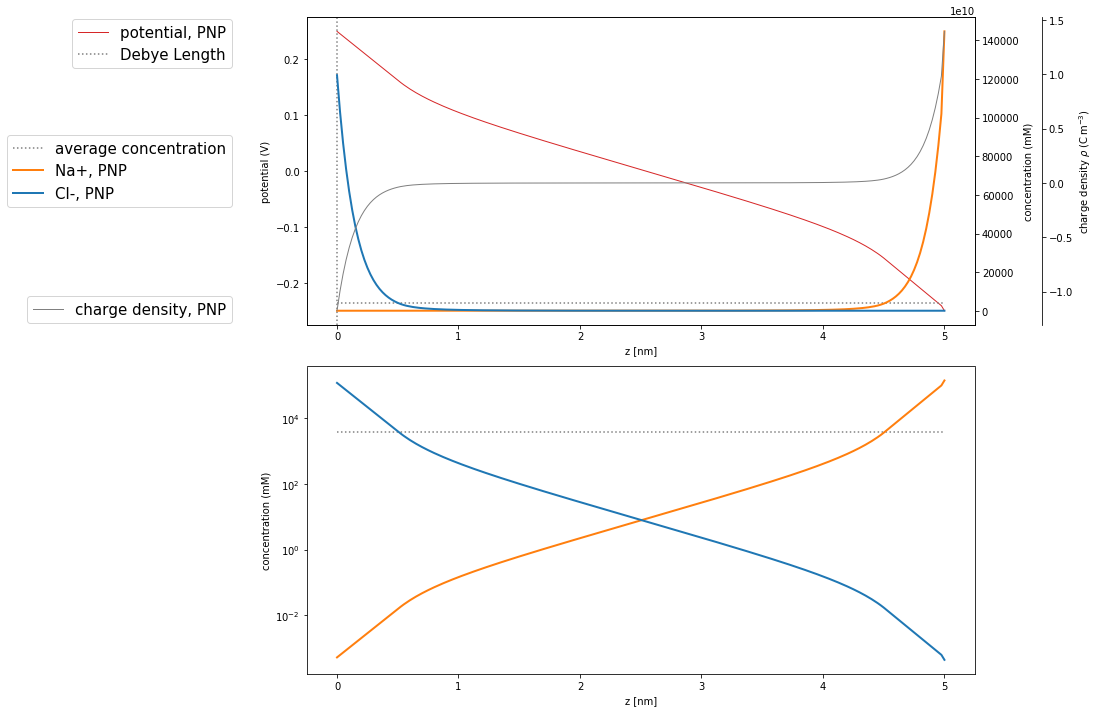

In [125]:
# analytic Poisson-Boltzmann distribution and numerical solution to full Poisson-Nernst-Planck system
x = np.linspace(0,L,100)

deb = debye(c, z)

fig, (ax1,ax4) = plt.subplots(nrows=2,ncols=1,figsize=[16,10])
ax1.set_xlabel('z [nm]')
ax1.plot(pnp.grid/sc.nano, pnp.potential, marker='', color='tab:red', label='potential, PNP', linewidth=1, linestyle='-')

ax2 = ax1.twinx()
ax2.plot(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax2.plot(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')

ax2.plot(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')
ax1.axvline(x=deb, label='Debye Length', color='grey', linestyle=':')

ax3 = ax1.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, ax3 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)
ax3.plot(pnp.grid/sc.nano, pnp.charge_density, label='charge density, PNP', color='grey', linewidth=1, linestyle='-')

ax4.semilogy(x/sc.nano, np.ones(x.shape)*c[0], label='average concentration', color='grey', linestyle=':')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[0], marker='', color='tab:orange', label='Na+, PNP', linewidth=2, linestyle='-')
ax4.semilogy(pnp.grid/sc.nano, pnp.concentration[1], marker='', color='tab:blue', label='Cl-, PNP', linewidth=2, linestyle='-')

ax1.set_xlabel('z [nm]')
ax1.set_ylabel('potential (V)')
ax2.set_ylabel('concentration (mM)')
ax3.set_ylabel(r'charge density $\rho \> (\mathrm{C}\> \mathrm{m}^{-3})$')
ax4.set_xlabel('z [nm]')
ax4.set_ylabel('concentration (mM)')

#fig.legend(loc='center')
ax1.legend(loc='upper right',  bbox_to_anchor=(-0.1,1.02), fontsize=15)
ax2.legend(loc='center right', bbox_to_anchor=(-0.1,0.5),  fontsize=15)
ax3.legend(loc='lower right',  bbox_to_anchor=(-0.1,-0.02), fontsize=15)

fig.tight_layout()
plt.show()

#### Potential at left and right hand side of domain

In [126]:
(pnp.potential[0],pnp.potential[-1])

(0.25, -0.25)

#### Residual cation flux at interfaces

In [127]:
( pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,0), pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(-1.0587911840678754e-22, 1.0658141036401503e-14)

#### Residual anion flux at interfaces

In [128]:
(pnp.leftControlledVolumeSchemeFluxBC(pnp.xij1,1),  pnp.rightControlledVolumeSchemeFluxBC(pnp.xij1,0) )

(2.4868995751603507e-14, 1.0658141036401503e-14)

#### Cation concentration at interfaces

In [129]:
(pnp.concentration[0,0],pnp.concentration[0,-1])

(0.0005113593697388644, 144702.37133964463)

#### Anion concentration at interfaces

In [130]:
(pnp.concentration[1,0],pnp.concentration[1,-1])

(121993.60112769733, 0.00043110955468776235)

#### Equilibrium cation and anion amount

In [131]:
( pnp.numberConservationConstraint(pnp.xij1,0,0), pnp.numberConservationConstraint(pnp.xij1,1,0) )

(32.50509450777841, 32.50509450777909)

#### Initial cation and anion amount

In [132]:
( pnp.numberConservationConstraint(pnp.xi0,0,0), pnp.numberConservationConstraint(pnp.xi0,1,0) )

(32.505094507778395, 32.505094507778395)

#### Species conservation

In [133]:
(pnp.numberConservationConstraint(pnp.xij1,0,
                                 pnp.numberConservationConstraint(pnp.xi0,0,0)), 
 pnp.numberConservationConstraint(pnp.xij1,1,
                                 pnp.numberConservationConstraint(pnp.xi0,1,0)) )

(1.4210854715202004e-14, 6.963318810448982e-13)

## Sampling
First, convert the physical concentration distributions into a callable "probability density":

In [134]:
pnp.concentration.shape

(2, 201)

In [135]:
distributions = [interpolate.interp1d(pnp.grid,pnp.concentration[i,:]) for i in range(pnp.concentration.shape[0])]

Normalization is not necessary here. Now we can sample the distribution of our $Na^+$ ions in z-direction.

[ continuous2discrete.py:255 - generate_structure() ]: Using uniform distribution along x and y direction.
[ continuous2discrete.py:257 - generate_structure() ]: Using distribution <scipy.interpolate.interpolate.interp1d object at 0x7ff86ddba408> along z direction.
[ continuous2discrete.py:271 - generate_structure() ]: Using [nan nan nan] grid as sampling support.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <function uniform at 0x7ff8754c1bf8> by 2.5e-09.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <function uniform at 0x7ff8754c1bf8> by 2.5e-09.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <scipy.interpolate.interpolate.interp1d object at 0x7ff86ddba408> by 1.7968760335485397e-05.
[ continuous2discrete.py:298 - generate_structure() ]: Drew (296, 3) samples from distributions.


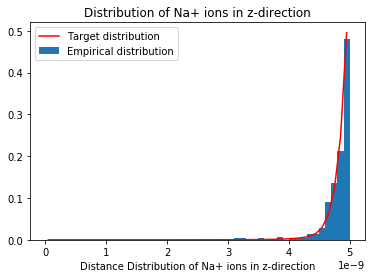

In [136]:
na_coordinate_sample = continuous2discrete(
    distribution=distributions[0], box=box_m, count=n_NaCl)
histx, histy, histz = get_histogram(na_coordinate_sample, box=box_m, n_bins=51)
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=distributions[0])

[ continuous2discrete.py:255 - generate_structure() ]: Using uniform distribution along x and y direction.
[ continuous2discrete.py:257 - generate_structure() ]: Using distribution <scipy.interpolate.interpolate.interp1d object at 0x7ff86dd67778> along z direction.
[ continuous2discrete.py:271 - generate_structure() ]: Using [nan nan nan] grid as sampling support.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <function uniform at 0x7ff8754c1bf8> by 2.5e-09.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <function uniform at 0x7ff8754c1bf8> by 2.5e-09.
[ continuous2discrete.py:289 - generate_structure() ]: Normalizing 'distribution' <scipy.interpolate.interpolate.interp1d object at 0x7ff86dd67778> by 1.825316159340641e-05.
[ continuous2discrete.py:298 - generate_structure() ]: Drew (296, 3) samples from distributions.


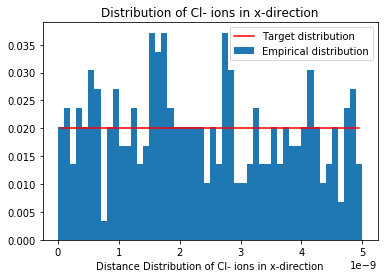

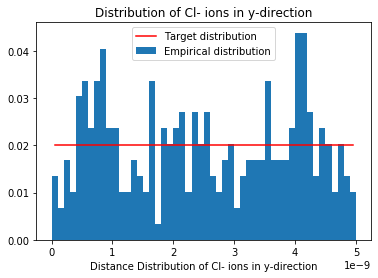

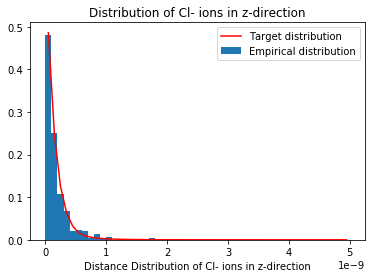

In [138]:
cl_coordinate_sample = continuous2discrete(
    distributions[1], box=box_m, count=n_NaCl)
histx, histy, histz = get_histogram(cl_coordinate_sample, box=box_m, n_bins=51)
plot_dist(histx, 'Distribution of Cl- ions in x-direction', reference_distribution=lambda x: np.ones(x.shape)*1/box_m[0])
plot_dist(histy, 'Distribution of Cl- ions in y-direction', reference_distribution=lambda x: np.ones(x.shape)*1/box_m[1])
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=distributions[1])

## Write to file
To visualize our sampled coordinates, we utilize ASE to export it to some standard format, i.e. .xyz or LAMMPS data file.
ASE speaks Ångström per default, thus we convert SI units:

In [139]:
sample_size = int(n_NaCl)

In [140]:
sample_size

296

In [141]:
na_atoms = ase.Atoms(
    symbols='Na'*sample_size,
    charges=[1]*sample_size,
    positions=na_coordinate_sample/sc.angstrom,
    cell=box_Ang,
    pbc=[1,1,0])

cl_atoms = ase.Atoms(
    symbols='Cl'*sample_size,
    charges=[-1]*sample_size,
    positions=cl_coordinate_sample/sc.angstrom,
    cell=box_Ang,
    pbc=[1,1,0])

system = na_atoms + cl_atoms

system

ase.io.write('NaCl_c_4_M_u_0.5_V_box_5x5x10nm_lambda_S_2_Ang.xyz',system,format='xyz')

In [142]:
# LAMMPS data format, units 'real', atom style 'full'
# before ASE 3.19.0b1, ASE had issues with exporting atom style 'full' in LAMMPS data file format, so do not expect this line to work for older ASE versions
ase.io.write('NaCl_c_4_M_u_0.5_V_box_5x5x10nm_lambda_S_2_Ang.lammps',system,format='lammps-data',units="real",atom_style='full')